In [1]:
import json
import logging
import os
import time
import numpy as np
import mxnet as mx

from collections import namedtuple

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
def train(current_host, hosts, num_cpus, num_gpus, channel_input_dirs, model_dir, hyperparameters, **kwargs):
    ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
    mx.random.seed(127)
    
    path='http://data.mxnet.io/models/imagenet-11k/'
    [mx.test_utils.download(path+'resnet-152/resnet-152-symbol.json'),
     mx.test_utils.download(path+'resnet-152/resnet-152-0000.params'),
     mx.test_utils.download(path+'synset.txt')]
    
    sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', 0)
    
    mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
    mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
        label_shapes=mod._label_shapes)
    mod.set_params(arg_params, aux_params, allow_missing=True)
    
    all_layers = sym.get_internals()

    hash_output = all_layers['flatten0_output']
    hash_output = mx.symbol.LogisticRegressionOutput(data=hash_output, name='sig')

    net = mx.symbol.Group([hash_output, all_layers["softmax_output"]])

    image_search_mod = mx.mod.Module(symbol=net, context=ctx, label_names=[ 'sig_label', 'softmax_label'])
    image_search_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
        label_shapes=image_search_mod._label_shapes)
    image_search_mod.set_params(arg_params, aux_params, allow_missing=False)
    
    return image_search_mod

In [3]:
def save(net, model_dir):
    net.save_checkpoint('%s/model' % model_dir, 0)
    
    shapes = open ( '%s/model-shapes.json' % model_dir, "w")
    json.dump([{"shape": net.data_shapes[0][1], "name": "data"}], shapes)
    shapes.flush()
    shapes.close()

In [4]:
def get_test_data(data_dir, batch_size, data_shape):
    return None

def get_train_data(data_dir, batch_size, data_shape):
    return None

In [5]:
def test(ctx, net, test_data):
    return None

In [6]:
def model_fn(model_dir):
    """
    Load the model. Called once when hosting service starts.

    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a network)
    """
    net, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(model_dir, 'model'), 0)

    image_search_mod = mx.mod.Module(symbol=net, context=mx.cpu(), label_names=[ 'sig_label', 'softmax_label'])
    image_search_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
        label_shapes=image_search_mod._label_shapes)
    image_search_mod.set_params(arg_params, aux_params, allow_missing=False)

    return image_search_mod

In [7]:
def transform_fn(net, data, input_content_type, output_content_type):
    """
    Transform a request using the model. Called once per request.

    :param net: The model.
    :param data: The request payload.
    :param input_content_type: The request content type.
    :param output_content_type: The (desired) response content type.
    :return: response payload and content type.
    """
    resp = []

    try:
        Batch = namedtuple('Batch', ['data'])
        
        parsed = json.loads(data)
        img = mx.nd.array([parsed])
        
        net.forward(Batch([img]))
        prob_hash = net.get_outputs()[0][0].asnumpy()

        prob_cat = net.get_outputs()[1][0].asnumpy()
        prob_cat = np.squeeze(prob_cat)
        index_cat = np.argsort(prob_cat)[::-1]
        categories = []
        for i in index_cat[0:10]:
            categories.append( [int(i), float(prob_cat[i]) ] )

        hash_ =  "".join( map(str, np.where(prob_hash >= 0.75, 1, 0) ) )
    except Exception as e:
        logging.error(e)

    return json.dumps({"categories": categories, "hash": hash_ }), output_content_type

## Testing the code

In [8]:
current_host='algo-1'
hosts=['algo-1']
num_cpus=4
num_gpus=1
channel_input_dirs={
    'training': '/opt/ml/input/data/training'
}
model_dir='/opt/ml/model'
hyperparameters = {
    "learning_rate": 0.001
}

In [9]:
from PIL import Image
def get_image(img_name):
    img = Image.open(img_name)
    img = img.resize((224, 224))
    img = np.transpose(img, (2,0,1))
    return img

In [10]:
class NumPyArangeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist() # or map(int, obj)
        return json.JSONEncoder.default(self, obj)

In [11]:
net = train(current_host, hosts, num_cpus, num_gpus, channel_input_dirs, model_dir, hyperparameters)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['sig_label', 'softmax_label'])
  warnings.warn(msg)


In [12]:
save(net, model_dir)

In [13]:
net = model_fn(model_dir)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['sig_label', 'softmax_label'])
  warnings.warn(msg)


In [14]:
img = get_image('cadeira.jpg')
data = json.dumps(img, cls=NumPyArangeEncoder)

input_content_type = 'application/json'
output_content_type = 'application/json'

transform_fn(net, data, input_content_type, output_content_type)

('{"categories": [[5176, 0.3802463412284851], [6439, 0.21439851820468903], [2606, 0.057544220238924026], [3173, 0.03890830650925636], [2990, 0.0227846447378397], [5174, 0.020044080913066864], [3482, 0.019117407500743866], [3266, 0.016844220459461212], [3483, 0.016691792756319046], [6998, 0.014003356918692589]], "hash": "001101001000000001000000111000000011101100010000010110000001111110001000110001000000000001001110011000001000000000010010011011001101000000011000010001110011000001011010110100110100011110001111110001100110011100011110100000000000100000100000001001010100101011001000000000110000000101001001100101011001100001100011010001000010000100000001100101101000011011000010100000100010000111000000100000010010000010001100000000010101001101111000010001000110001111000001000010000001000000111000110001010001000010101011110000000000010101011000101010000010000011100101000000000110000110000100000101111001010011110000010100001001101100010010011001100011111011001100000000011100000000101000100100

## Saving the script

In [15]:
import inspect

In [16]:
code = open('visual.py', 'w')
code.write("""
import json
import logging
import os
import time
import numpy as np
import mxnet as mx

from collections import namedtuple

""")
for func in [train, save, get_test_data, get_train_data, test, model_fn, transform_fn]:
    code.write(inspect.getsource(func) + '\n')
code.flush()
code.close()

## Deploy the model to a Sagemaker Endpoint

In [17]:
import sagemaker
import cv2
import pandas as pd
import tarfile
import os

from sagemaker.mxnet import MXNet

In [18]:
model_tarball = '/tmp/model.tar.gz'
entry_point = 'visual.py'
py_version='py3'
endpoint_name='visual-search'
model_name='visual-search'

In [19]:
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

In [20]:
tarball = tarfile.open(model_tarball, "w:gz" )
for f in os.listdir(model_dir):
    tarball.add(os.path.join(model_dir, f), arcname=f)
tarball.close()

In [21]:
!tar -tzvf $model_tarball

-rw-rw-r-- ec2-user/ec2-user 45 2018-03-23 15:55 model-shapes.json
-rw-rw-r-- ec2-user/ec2-user 325144599 2018-03-23 15:55 model-0000.params
-rw-rw-r-- ec2-user/ec2-user    292835 2018-03-23 15:55 model-symbol.json


In [22]:
model_data = sagemaker_session.upload_data(path=model_tarball, key_prefix='data/visual')
print(model_data)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862


s3://sagemaker-us-east-1-715445047862/data/visual/model.tar.gz


In [66]:
m = sagemaker.mxnet.model.MXNetModel(model_data=model_data, role=role, entry_point=entry_point, py_version=py_version)

In [67]:
%%time
# takes around 8mins
m.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name=endpoint_name)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862
INFO:sagemaker:Creating model with name: sagemaker-mxnet-py3-cpu-2018-03-23-17-23-13-120
INFO:sagemaker:Creating endpoint with name visual-search


---------------------------------------------------------------------------------------------------!CPU times: user 528 ms, sys: 28 ms, total: 556 ms
Wall time: 8min 28s


## Calling the endpoint

In [12]:
%matplotlib inline

import boto3
import matplotlib.pyplot as plt
import json
import numpy as np

from sagemaker.predictor import json_serializer, json_deserializer
from PIL import Image

In [6]:
endpoint_name='visual-search'

synset = open('synset.txt', 'r')
object_classes = []
for l in synset:
    object_classes.append(l.split(' ')[1].replace('\n', ''))
synset.close()

In [7]:
class NumPyArangeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist() # or map(int, obj)
        return json.JSONEncoder.default(self, obj)

In [8]:
def get_image(img_name):
    img = Image.open(img_name)
    img = img.resize((224, 224))
    img = np.transpose(img, (2,0,1))
    return img

In [9]:
def hamming2(s1, s2):
    """Calculate the Hamming distance between two bit strings"""
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

In [10]:
def get_hash(img):
    sm = boto3.client('sagemaker-runtime')
    response = sm.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(img, cls=NumPyArangeEncoder)
    )
    response = json_deserializer(response['Body'], response['ContentType'])  
    
    return response

In [13]:
%%time
image = get_image('criado.jpg')
item_hash = get_hash(image)

CPU times: user 48 ms, sys: 12 ms, total: 60 ms
Wall time: 6.9 s


In [14]:
categories = list(map( lambda x: ( object_classes[x[0]], x[1]), item_hash['categories']))

In [15]:
metadata = json.loads(open("mobly.json", "r").read())

In [16]:
dist = {}
for i in metadata:
    dist[i] = hamming2( item_hash['hash'], metadata[i]["properties"]["hash"] )

In [28]:
result = []
for w in sorted(dist, key=dist.get, reverse=False):
    result.append( (dist[w], metadata[w]['properties'][ 'image_path']) )

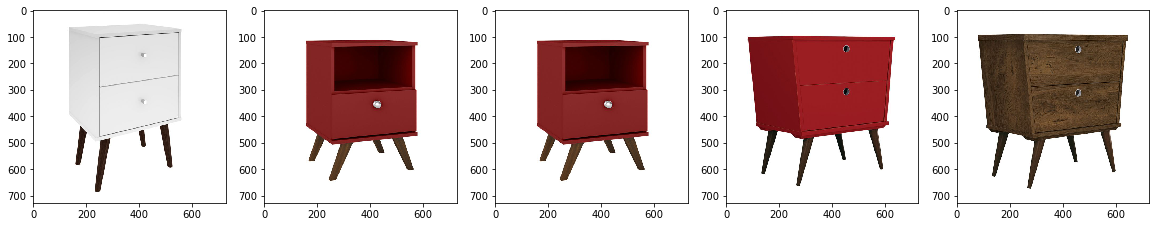

In [26]:
f, axarr = plt.subplots(1, 5, figsize=(20,12))
for i in range(5):
    im = Image.open(result[5:10][i][1])
    frame = axarr[i].imshow(im)   
plt.show() 

## Deleting the endpoint

In [65]:
%%time
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: visual-search


CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 329 ms
